# GADM with GeoPandas
For CAMS71 we need to define regions in the model
that will stand for different European cities.

Origginally the city administrative boundaries from [GADM](https://gadm.org),
as google earth/maps files (kmz) and then the filws wehre parsed with
different command line tools. Then the coodrinates were processed on a spreadsheet.
The preocess was slow, and could did not prone to errors.

On this notebook, we'll streamline the process:
- Extract the city shape objects from [GADM](https://gadm.org) shapefiles with GeoPandas
- Calculate model regions.
- Vilsualize the cities/regions with GeoViews


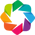

In [1]:
import numpy as np
import pandas as pd
import shapely as shp
import geopandas as gpd
import holoviews as hv
import geoviews as gv

from io import StringIO

tiles = 'https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png'
hv.notebook_extension('bokeh')

# GADM maps and data
> GADM provides maps and spatial data for all countries and their sub-divisions. You can browse our maps or download the data to make your own maps.
https://gadm.org/index.html

> [...] the whole world you can download version 2.8 as a single layer [ESRI geodatabase](https://biogeo.ucdavis.edu/data/gadm2.8/gadm28.gdb.zip) [...]
https://gadm.org/download_world.html

In [2]:
gadm28 = '/lustre/storeB/project/fou/kl/emep/CAMS71/gadm28.gdb.zip'
%time gadm = gpd.read_file(gadm28)
gadm.head()

CPU times: user 1min 4s, sys: 4.33 s, total: 1min 9s
Wall time: 1min 10s


UID  ID_0  ISO       NAME_0  ID_1      NAME_1 VARNAME_1 NL_NAME_1 HASC_1  \
0  1.0     1  AFG  Afghanistan   1.0  Badakhshan  Badahšan      None  AF.BD   
1  2.0     1  AFG  Afghanistan   1.0  Badakhshan  Badahšan      None  AF.BD   
2  3.0     1  AFG  Afghanistan   1.0  Badakhshan  Badahšan      None  AF.BD   
3  4.0     1  AFG  Afghanistan   1.0  Badakhshan  Badahšan      None  AF.BD   
4  5.0     1  AFG  Afghanistan   1.0  Badakhshan  Badahšan      None  AF.BD   

   CCN_1                        ...                         NAME_5 CCN_5  \
0    NaN                        ...                           None   NaN   
1    NaN                        ...                           None   NaN   
2    NaN                        ...                           None   NaN   
3    NaN                        ...                           None   NaN   
4    NaN                        ...                           None   NaN   

  CCA_5 TYPE_5 ENGTYPE_5 REGION  VARREGION Shape_Length Shape_Area  \
0  None   None      None   None       None     3.464540   0.304174   
1  None   None      None   None       None     2.980827   0.300430   
2  None   None      None   None       None     2.395813   0.298038   
3  None   None      None   None       None     2.534993   0.158482   
4  None   None      None   None       None     2.846146   0.353425   

                                            geometry  
0  (POLYGON ((71.18168640136724 36.49195861816412...  
1  (POLYGON ((71.33762359619141 38.11840820312511...  
2  (POLYGON ((70.09976196289062 37.00258255004883...  
3  (POLYGON ((71.3193359375 37.24847793579107, 71...  
4  (POLYGON ((71.18168640136724 36.49195861816412...  

[5 rows x 61 columns]

## Define cities

In [3]:
cityDef = u"""city,ISO,adm,region
Vienna    ,AUT,2,Wien
Brussels  ,BEL,2,Bruxelles
Sofia     ,BGR,2,Stolichna
Zagreb    ,HRV,2,Zagreb
Nicosia   ,CYP,1,Nicosia
Prague    ,CZE,2,Praha - východ;Praha - západ;Praha 1;Praha 10;Praha 11;Praha 12;Praha 13;Praha 14;Praha 15;Praha 16;Praha 17;Praha 18;Praha 19;Praha 2;Praha 20;Praha 21;Praha 22;Praha 3;Praha 4;Praha 5;Praha 6;Praha 7;Praha 8;Praha 9
Copenhagen,DNK,2,København
Tallinn   ,EST,2,Tallinn
Helsinki  ,FIN,4,Helsinki
Paris     ,FRA,2,Paris;Hauts-de-Seine;Val-de-Marne;Seine-Saint-Denis
Berlin    ,DEU,2,Berlin
Athens    ,GRC,3,Athens
Budapest  ,HUN,2,Budapesti
Reykjavik ,ISL,2,Reykjavík
Dublin    ,IRL,1,Dublin
Rome      ,ITA,3,Roma
Riga      ,LVA,2,Riga
Vilnius   ,LTU,2,Vilniaus
Luxembourg,LUX,3,Luxembourg
Valletta  ,MLT,0,Malta
Amsterdam ,NLD,2,Amsterdam
Rotterdam ,NLD,2,Rotterdam
Oslo      ,NOR,2,Oslo
Warsaw    ,POL,2,Warsaw
Lisbon    ,PRT,2,Lisboa
Bucharest ,ROU,2,Municipiul Bucuresti
Bratislava,SVK,2,Bratislava I;Bratislava II;Bratislava III;Bratislava IV;Bratislava V
Ljubljana ,SVN,2,Ljubljana
Barcelona ,ESP,4,Barcelona
Madrid    ,ESP,4,Madrid
Stockholm ,SWE,2,Stockholm
Bern      ,CHE,2,Bern
Zurich    ,CHE,2,Zürich
London    ,GBR,2,Barking and Dagenham;Bexley;Brent;Bromley;Camden;Croydon;Ealing;Enfield;Greenwich;Hackney;Hammersmith and Fulham;Haringey;Harrow;Havering;Hillingdon;Hounslow;Islington;Lambeth;Lewisham;Merton;Newham;Redbridge;Richmond upon Thames;Southwark;Sutton;Tower Hamlets;Waltham Forest;Wandsworth
Milan     ,ITA,3,Milano
Lille     ,FRA,3,Lille
Lyon      ,FRA,3,Lyon
Frankfurt ,DEU,2,Frankfurt am Main
Geneva    ,CHE,2,Genève
"""

df = gpd.GeoDataFrame(
    pd.read_csv(
        StringIO(cityDef), sep=',', index_col='city',
        converters=dict(
            city=str.strip,
            region=lambda x: x.split(';'),
        )
    )
)
df.tail()

ISO  adm               region
city                                    
Milan      ITA    3             [Milano]
Lille      FRA    3              [Lille]
Lyon       FRA    3               [Lyon]
Frankfurt  DEU    2  [Frankfurt am Main]
Geneva     CHE    2             [Genève]

## Select cities

In [4]:
europe = list(df.ISO)
vnames = 'ISO geometry NAME_0 NAME_1 NAME_2 NAME_3 NAME_4 Shape_Area'.split()
europe = gadm[gadm['ISO'].isin(europe)][vnames]

europe['city'] = ''
print('Shapes by city/region:')
for city, row in df.iterrows():
    key = 'NAME_%s'%row.adm
    ind = europe[key].isin(row.region)
    europe.loc[ind,'city'] = city
    print("%-10s %3d"%(city,sum(ind)))

europe = europe[europe.city !='']

Shapes by city/region:
Vienna      23
Brussels    19
Sofia        1
Zagreb       1
Nicosia      1
Prague      24
Copenhagen   1
Tallinn     10
Helsinki     1
Paris      143
Berlin       1
Athens       1
Budapest     1
Reykjavik    1
Dublin       1
Rome         1
Riga         1
Vilnius      1
Luxembourg  24
Valletta     1
Amsterdam    1
Rotterdam    1
Oslo         1
Warsaw       1
Lisbon      53
Bucharest    1
Bratislava   5
Ljubljana    1
Barcelona    1
Madrid       1
Stockholm    1
Bern        13
Zurich      32
London      28
Milan        1
Lille      124
Lyon       170
Frankfurt    1
Geneva      46


### One shape by city/region

In [5]:
# https://gis.stackexchange.com/a/128072
import pyproj    
from functools import partial
area_km2 = lambda x: shp.ops.transform(
    partial(
        pyproj.transform,
        pyproj.Proj(init='EPSG:4326'),
        pyproj.Proj(
            proj='aea',
            lat1=x.bounds[1],
            lat2=x.bounds[3])
    ),
    x
).area*1e-6 # m^2 to km^2

In [6]:
df['GADM'] = europe.dissolve(by='city').geometry
df['area'] = df.GADM.apply(area_km2)
df.reset_index(inplace=True)
df.head()

city  ISO  adm       region  \
0    Vienna  AUT    2       [Wien]   
1  Brussels  BEL    2  [Bruxelles]   
2     Sofia  BGR    2  [Stolichna]   
3    Zagreb  HRV    2     [Zagreb]   
4   Nicosia  CYP    1    [Nicosia]   

                                                GADM         area  
0  POLYGON ((16.22273063659674 48.12640380859381,...   417.274438  
1  POLYGON ((4.40336465835577 50.77439117431646, ...   156.299226  
2  POLYGON ((23.64644241333013 42.82651519775402,...  1352.584934  
3  POLYGON ((15.78822612762445 45.7462615966798, ...   641.206509  
4  POLYGON ((32.76751708984386 34.90252685546875,...  1971.748433

In [7]:
%%opts Polygons [tools=['hover'] width=650 height=300]

(
    gv.WMTS(tiles) * \
    gv.Polygons(europe,
                vdims=['city'],
                group='GADM') + \
    gv.WMTS(tiles) * \
    gv.Polygons(df.rename(columns={'GADM':'geometry'}), 
                vdims=['city'],
                group='Single Shape')
).cols(1)

:Layout
   .GADM.I         :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .GADM.I :Polygons   [Longitude,Latitude]   (city)
   .Single_Shape.I :Overlay
      .WMTS.I         :WMTS   [Longitude,Latitude]
      .Single_Shape.I :Polygons   [Longitude,Latitude]   (city)

## Model grid

### Bounding box

In [8]:
df['bounds'] = df.GADM.apply(lambda x: shp.geometry.box(*x.bounds))
df['boxarea'] = df.bounds.apply(area_km2)

df.head()

city  ISO  adm       region  \
0    Vienna  AUT    2       [Wien]   
1  Brussels  BEL    2  [Bruxelles]   
2     Sofia  BGR    2  [Stolichna]   
3    Zagreb  HRV    2     [Zagreb]   
4   Nicosia  CYP    1    [Nicosia]   

                                                GADM         area  \
0  POLYGON ((16.22273063659674 48.12640380859381,...   417.274438   
1  POLYGON ((4.40336465835577 50.77439117431646, ...   156.299226   
2  POLYGON ((23.64644241333013 42.82651519775402,...  1352.584934   
3  POLYGON ((15.78822612762445 45.7462615966798, ...   641.206509   
4  POLYGON ((32.76751708984386 34.90252685546875,...  1971.748433   

                                              bounds      boxarea  
0  POLYGON ((16.5804233551026 48.1214714050293, 1...   666.562614  
1  POLYGON ((4.472226142883301 50.76710510253912,...   256.487737  
2  POLYGON ((23.65198135375982 42.41115570068359,...  2618.910657  
3  POLYGON ((16.21375465393066 45.62261962890631,...  1370.364772  
4  POLYGON ((33.52307128906244 34.87968826293945,...  3146.926727

### Roundup to model grid

In [9]:
# MACC14 grid midpoints
grid = dict(
    x=dict(start=-30, stop=45, step=0.25 , name='lon', units='degrees_east'),
    y=dict(start= 30, stop=76, step=0.125, name='lat', units='degrees_north'),
)

# 1st boundary
first_bnd = lambda start, step, **kwa: start-step*0.5
for k,v in grid.items():
    grid[k]['first'] = first_bnd(**v)

# round up/down to grid
minb = lambda x, first, step, **kwa: np.floor((x-first)/step)*step+first
maxb = lambda x, first, step, **kwa: np.ceil( (x-first)/step)*step+first
bbox = lambda x0,y0,x1,y1: dict(
    minx=minb(x0, **grid['x']),
    miny=minb(y0, **grid['y']),
    maxx=maxb(x1, **grid['x']),
    maxy=maxb(y1, **grid['y']),
)

In [10]:
df['grid'] = df.GADM.apply(lambda x: shp.geometry.box(**bbox(*x.bounds)))
df['gridarea'] = df.grid.apply(area_km2)

df.head()

city  ISO  adm       region  \
0    Vienna  AUT    2       [Wien]   
1  Brussels  BEL    2  [Bruxelles]   
2     Sofia  BGR    2  [Stolichna]   
3    Zagreb  HRV    2     [Zagreb]   
4   Nicosia  CYP    1    [Nicosia]   

                                                GADM         area  \
0  POLYGON ((16.22273063659674 48.12640380859381,...   417.274438   
1  POLYGON ((4.40336465835577 50.77439117431646, ...   156.299226   
2  POLYGON ((23.64644241333013 42.82651519775402,...  1352.584934   
3  POLYGON ((15.78822612762445 45.7462615966798, ...   641.206509   
4  POLYGON ((32.76751708984386 34.90252685546875,...  1971.748433   

                                              bounds      boxarea  \
0  POLYGON ((16.5804233551026 48.1214714050293, 1...   666.562614   
1  POLYGON ((4.472226142883301 50.76710510253912,...   256.487737   
2  POLYGON ((23.65198135375982 42.41115570068359,...  2618.910657   
3  POLYGON ((16.21375465393066 45.62261962890631,...  1370.364772   
4  POLYGON ((33.52307128906244 34.87968826293945,...  3146.926727   

                                                grid     gridarea  
0  POLYGON ((16.625 48.0625, 16.625 48.4375, 16.1...  1548.329315  
1  POLYGON ((4.625 50.6875, 4.625 50.9375, 4.125 ...   980.063466  
2  POLYGON ((23.875 42.3125, 23.875 42.9375, 22.8...  5695.430691  
3  POLYGON ((16.375 45.5625, 16.375 46.0625, 15.6...  3239.543229  
4  POLYGON ((33.625 34.8125, 33.625 35.3125, 32.3...  6324.772196

In [11]:
%%opts Polygons [tools=['hover'] width=650 height=300]

gv.WMTS(tiles) * \
gv.Polygons(df.rename(columns={'grid':'geometry'}), 
            vdims=['city','area',('boxarea','box'),('gridarea','grid')]) * \
gv.Polygons(df.rename(columns={'bounds':'geometry'})) * \
gv.Polygons(df.rename(columns={'GADM':'geometry'}))

:Overlay
   .WMTS.I       :WMTS   [Longitude,Latitude]
   .Polygons.I   :Polygons   [Longitude,Latitude]   (city,area,boxarea,gridarea)
   .Polygons.II  :Polygons   [Longitude,Latitude]
   .Polygons.III :Polygons   [Longitude,Latitude]